In [1]:
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append('../src/')
from normalizing_flows import NormalizingFlow
from utils import random_normal_samples, plot_all_potentials
import argparse
from os.path import join as pjoin
from densities import (pot_1, pot_2, pot_3, pot_4)
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import torch.nn.functional as F

# Define potential functions

In [2]:
# For reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# Copying here to change the xlimit to better visualize these functions
def plot_pot_func(pot_func, ax=None):
    if ax is None:
        _, ax = plt.subplots(1)
    x = np.linspace(-4, 4, 800)
    y = np.linspace(-4, 4, 800)
    xx, yy = np.meshgrid(x, y)
    in_tens = torch.Tensor(np.vstack([xx.ravel(), yy.ravel()]).T)
    z = (torch.exp(pot_func(in_tens))).numpy().reshape(xx.shape)

    cmap = plt.get_cmap('inferno')
    ax.contourf(x, y, z.reshape(xx.shape), cmap=cmap)

In [4]:
def pot_5(z):

    X = torch.tensor([[-1.,1.], [1.,1.]])
    y = torch.tensor([0., 1.])
 
    y_preds = torch.sigmoid(torch.mm(X, z.T))
    # compute cross entropy loss for every beta given:
    cel_fn = torch.nn.BCELoss(reduction = 'sum') ## instantiates binary cross entropy loss function class, see # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
    cels = torch.tensor([cel_fn(y_preds[:, j], y ) for j in range(y_preds.shape[1])]) # shape is l
   
    # compute l2 norm^2 of input
    z_1, z_2 = z[:, 0], z[:, 1]
    norm2 = z_1.pow(2) + z_2.pow(2)

    return -cels - .1 * norm2
 
    
def pot_6(z): # slight variant of pot_5, makes it oblong
    X = torch.tensor([[2.,1.], [6.,1.]])
    y = torch.tensor([0.,1.])
 
    y_preds = torch.sigmoid(torch.mm(X,z.T))
    # compute cross entropy loss for every beta given:
    cel_fn = torch.nn.BCELoss(reduction = 'sum' ) ## instantiates binary cross entropy loss function class, see # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
    cels = torch.tensor([cel_fn(y_preds[:, j], y ) for j in range(y_preds.shape[1])]) # shape is l
   
    # compute l2 norm^2 of input
    z_1, z_2 = z[:, 0], z[:, 1]
    norm2 = z_1.pow(2) + z_2.pow(2)
    return -cels - .1* norm2


# Simplify the application of BCELoss 
def pot_5_alt(z):
    X = torch.tensor([[-1.,1.], [1.,1.]])
    y = torch.tensor([[0., 1.] for _ in range(z.shape[0])])
 
    y_preds = torch.sigmoid(torch.mm(X, z.T))

    cel_fn = torch.nn.BCELoss(reduction='none')
    cels = cel_fn(y_preds.T, y)
    cels = cels.sum(1)
       
    # compute l2 norm^2 of input
    z_1, z_2 = z[:, 0], z[:, 1]
    norm2 = z_1.pow(2) + z_2.pow(2)

    return -cels - .1 * norm2

# Simplify the application of BCELoss 
def pot_6_alt(z):
    X = torch.tensor([[2.,1.], [6.,1.]])
    y = torch.tensor([[0., 1.] for _ in range(z.shape[0])])
 
    y_preds = torch.sigmoid(torch.mm(X, z.T))
    
    cel_fn = torch.nn.BCELoss(reduction='none')
    cels = cel_fn(y_preds.T, y)
    cels = cels.sum(1)
       
    # compute l2 norm^2 of input
    z_1, z_2 = z[:, 0], z[:, 1]
    norm2 = z_1.pow(2) + z_2.pow(2)

    return -cels - .1 * norm2

# Plot potentials 

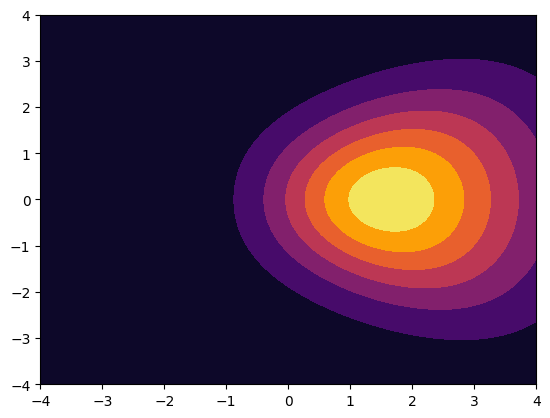

In [5]:
plot_pot_func(pot_5)

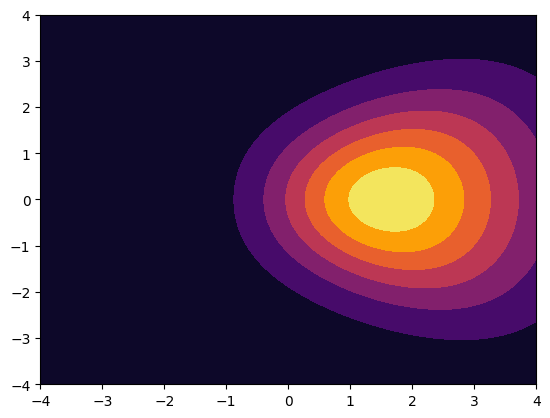

In [6]:
plot_pot_func(pot_5_alt)

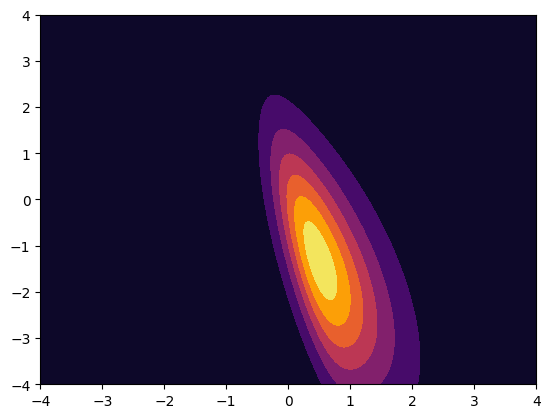

In [7]:
plot_pot_func(pot_6)

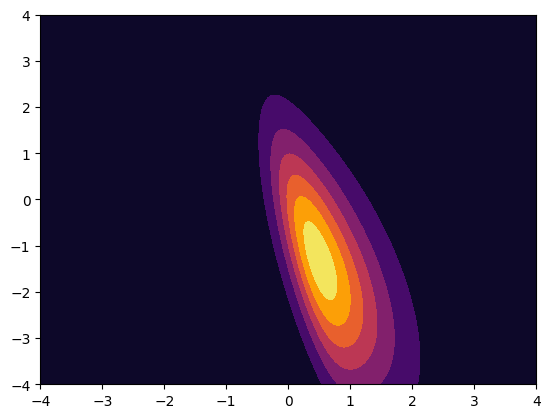

In [8]:
plot_pot_func(pot_6_alt)

# Define optimization loop

In [9]:
def train_loop(target_density, lr, momentum, n_flows, n_iters, verbose=True):

    model = NormalizingFlow(2, n_flows)

    #RMSprop is what they used in renzende et al
    opt = torch.optim.RMSprop(
        params=model.parameters(),
        lr=lr,
        momentum=momentum
    )
    scheduler = ReduceLROnPlateau(opt, 'min', patience=100, verbose=True)
    losses = []

    for iter_ in range(n_iters):
        if iter_ % 100 == 0 and verbose:
            print("Iteration {}".format(iter_))

        samples = Variable(random_normal_samples(1000), requires_grad=True)

        z_k, sum_log_det = model(samples)
        log_p_x = target_density(z_k)

        # Reverse KL since we can evaluate target density but can't sample
        loss = (- sum_log_det - (log_p_x)).mean()
    
        opt.zero_grad()
        loss.backward()
        opt.step()
        scheduler.step(loss)
       

        losses.append(loss.item())
     
        if (iter_ % 100 == 0) and verbose:
            print("Loss {}".format(loss.item()))
    return losses, model


# Potential 5 (alternate version)

In [20]:
losses, model = train_loop(pot_5_alt, lr=1e-3, momentum=0, n_flows=5, n_iters=900, verbose=True)

Iteration 0
Loss 2.008981943130493
Iteration 100
Loss 1.5334223508834839
Iteration 200
Loss 1.2742327451705933
Iteration 300
Loss 1.070178747177124
Iteration 400
Loss 0.8840283751487732
Iteration 500
Loss 0.921326756477356
Iteration 600
Loss 0.8245847225189209
Epoch 00665: reducing learning rate of group 0 to 1.0000e-04.
Iteration 700
Loss 0.8442105054855347
Epoch 00766: reducing learning rate of group 0 to 1.0000e-05.
Iteration 800
Loss 0.8731296062469482
Epoch 00867: reducing learning rate of group 0 to 1.0000e-06.


Text(0.5, 1.0, 'losses')

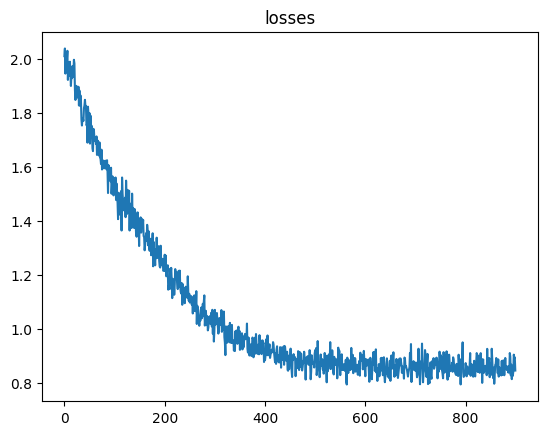

In [21]:
# Look at losses
plt.plot(range(len(losses)), losses)
plt.title('losses')

In [24]:
normal_samples = random_normal_samples(
        10000)
samples = ((model.sample(normal_samples)).detach().numpy())

Text(0.5, 1.0, 'KDE')

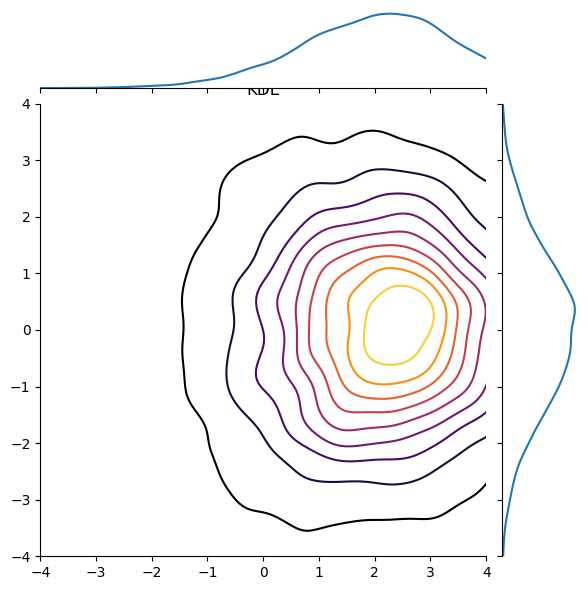

In [25]:
cmap = plt.get_cmap('inferno')
sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind='kde', cmap=cmap)

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title('KDE')

Text(0.5, 1.0, 'Samples')

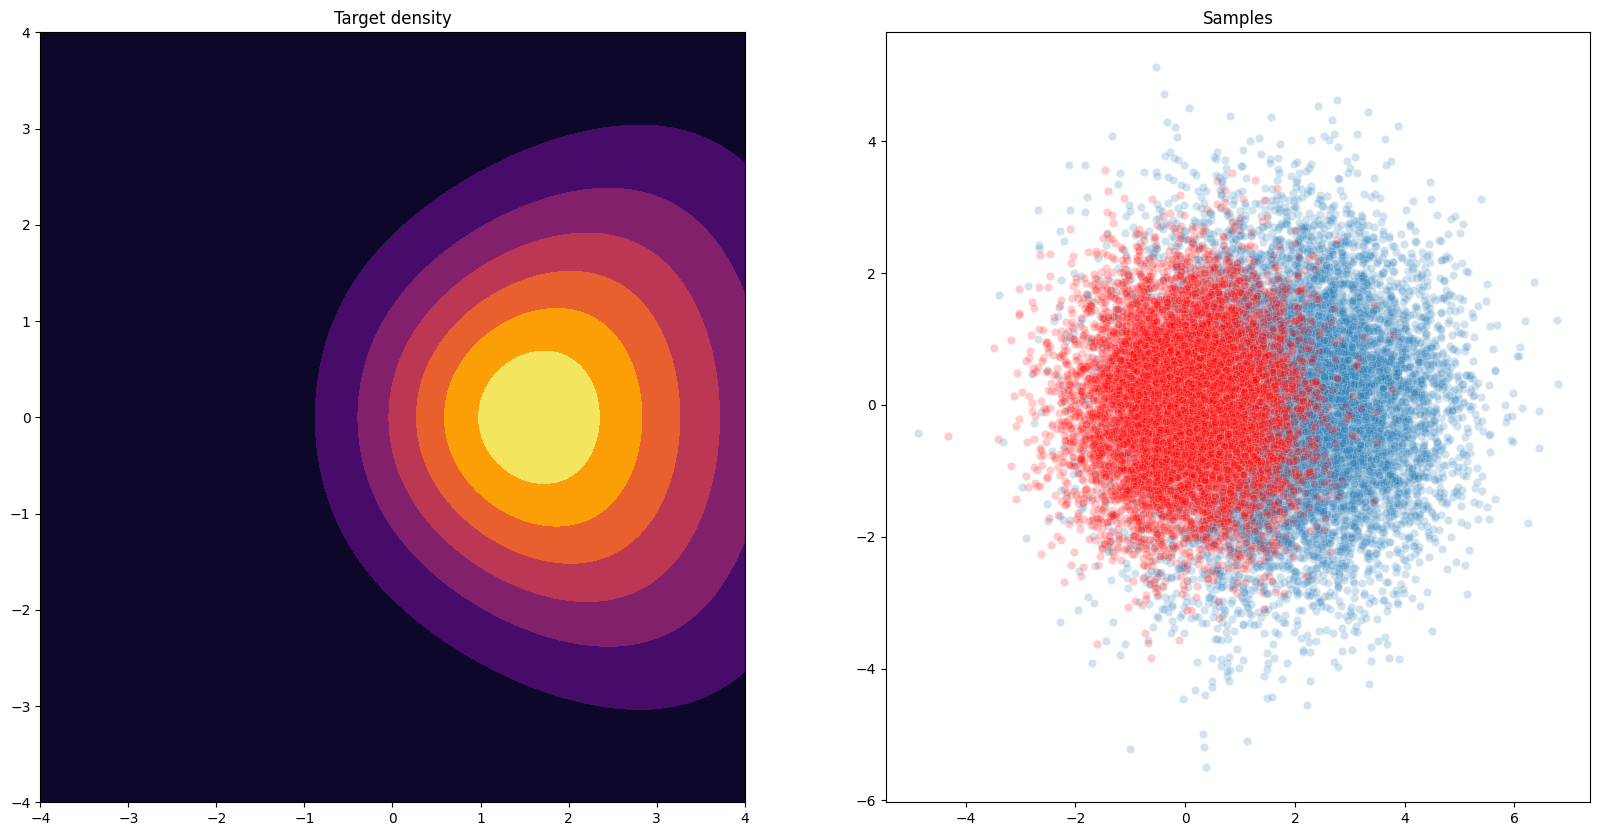

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat

plot_pot_func(pot_5_alt, axes[0])
axes[0].set_title('Target density')

sns.scatterplot(x=samples[:, 0], y=samples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

# Uncomment to compare with the untransformed samples
#sns.scatterplot(x=normal_samples[:, 0], y=normal_samples[:, 1], alpha=.2, ax=axes[1], c='r')
axes[1].set_title('Samples')


# Potential 6, (alternate version)

In [15]:
losses, model = train_loop(pot_6_alt, lr=1e-3, momentum=0, n_flows=5, n_iters=500)

Iteration 0
Loss 3.9097630977630615
Iteration 100
Loss 2.8820366859436035
Iteration 200
Loss 2.671529531478882
Iteration 300
Loss 2.4384095668792725
Iteration 400
Loss 2.3229854106903076


In [16]:
samples = ((model.sample(
    random_normal_samples(
        10000))).detach().numpy())

Text(0.5, 1.0, 'KDE')

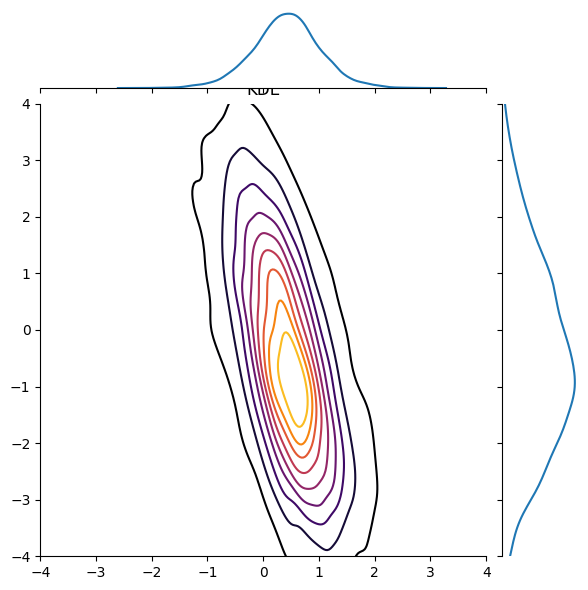

In [17]:
cmap = plt.get_cmap('inferno')
sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind='kde', cmap=cmap)

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title('KDE')

Text(0.5, 1.0, 'Samples')

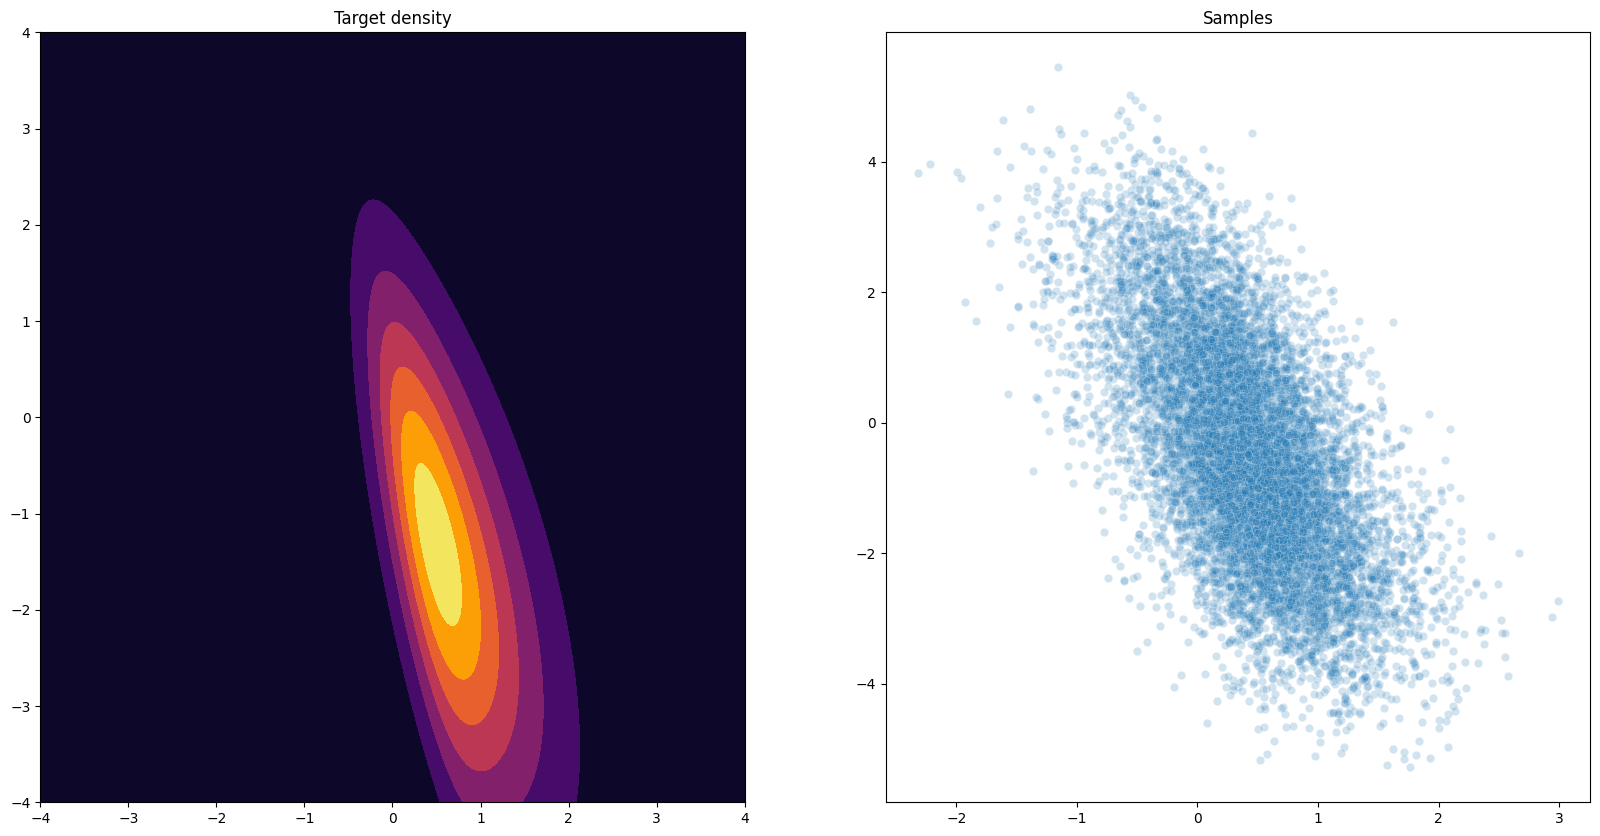

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes = axes.flat

plot_pot_func(pot_6_alt, axes[0])
axes[0].set_title('Target density')

sns.scatterplot(x=samples[:, 0], y=samples[:, 1], alpha=.2, ax=axes[1])
axes[1].set_title('Samples')

